<a href="https://colab.research.google.com/github/HagerDakroury/handwritten-digits-classification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


#mounting my google drive where the dataset is saved
# from google.colab import drive
# drive.mount('/content/drive')

#extracting the dataset
!tar xvzf /content/drive/MyDrive/trainingSet.tar.gz




In [10]:
def Load_data(directory):
  #fitting the data into a dataset
  #image_size=(28,28)
  #training to validation ratio 8:2
  #seed is random

  #the training dataset
  t_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory, labels='inferred',label_mode='int',color_mode='rgb',
      batch_size=32, image_size=(28,28), validation_split=0.2,
      subset="training",seed=387
  )

  #the validation dataset 
  v_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory, labels='inferred',label_mode='int', color_mode='rgb',
      batch_size=32, image_size=(28,28), validation_split=0.2,
      subset="validation",seed=387
  )

  #preprocessing the dataset

  #1.reshaping to a single


  return t_dataset,v_dataset


In [13]:

import numpy as np

t_dataset,v_dataset=Load_data("/content/trainingSet")
from keras.optimizers import SGD


#keeping the data into memory after they're loaded to avoid I/O blocking 
AUTOTUNE = tf.data.AUTOTUNE
t_ds = t_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
v_ds = v_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#resclaing the dataset
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

t_ds = t_ds.map(lambda x, y: (normalization_layer(x), y))
v_ds = v_ds.map(lambda x, y: (normalization_layer(x), y))


model = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(10)
])

# compile model
# opt = SGD(lr=0.01, momentum=0.9)
# model.compile(optimizer=opt, loss=, metrics=['accuracy'])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10
history = model.fit(
  t_ds,
  validation_data=v_ds,
  epochs=epochs
)


Found 42000 files belonging to 10 classes.
Using 33600 files for training.
Found 42000 files belonging to 10 classes.
Using 8400 files for validation.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               540900    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 542,806
Trainable params: 542,806
Non-trainable params: 0
_____________________________

> 98.226


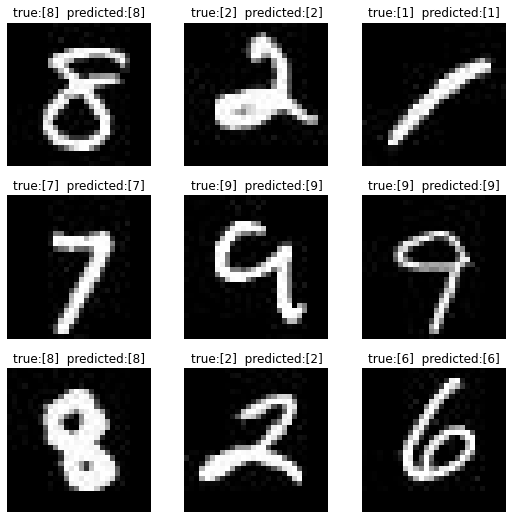

In [21]:
#checking accuracy
val_acc = history.history['val_accuracy']
print('> %.3f' % (val_acc[9] * 100.0))

import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

class_names = t_dataset.class_names 
plt.figure(figsize=(9, 9))
for images, labels in t_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #predicting the image 
        img=images[i]
        img = img_to_array(img)
        img = img.reshape(1, 28, 28, 3)
        img = img.astype('float32')
        img = img / 255.0
        predict=np.argmax(model.predict(img),axis=-1)
        # plt.title("predicted:"+np.array_str(predict))
        plt.title("true:"+"["+class_names[labels[i]]+"]  "+"predicted:"+np.array_str(predict))

        plt.axis("off")